In [1]:
"""
Created on Tuesday, Nov 6th 2024
@author: Kaisheng Lin, School of Electronics, Peking University, China
@Summary: GRE sequence (non-balanced SSFP), implemented with PyPulseq and compatible with MaSeq.
"""

import os
import sys
import matplotlib.pyplot as plt

# Use os.getcwd() to get the current working directory
main_directory = os.getcwd()
parent_directory = os.path.dirname(main_directory)
parent_directory = os.path.dirname(parent_directory)


# Define the subdirectories you want to add to sys.path
subdirs = ['MaSeq', 'marcos_client']

# Add the subdirectories to sys.path
for subdir in subdirs:
    full_path = os.path.join(parent_directory, subdir)
    sys.path.append(full_path)
#******************************************************************************


In [3]:
from seq.utils import sort_data_implicit, plot_nd, ifft_2d, combine_coils
import pypulseq as pp
import numpy as np
import seq.mriBlankSeq as blankSeq   
import configs.units as units
import scipy.signal as sig
import experiment_multifreq as ex
import configs.hw_config_pseq as hw
from flocra_pulseq.interpreter_pseq import PseqInterpreter
from pypulseq.convert import convert

class TSESingleSlicePSEQ(blankSeq.MRIBLANKSEQ):
    def __init__(self):
        super(TSESingleSlicePSEQ, self).__init__()
        # Input the parameters
        self.output = None
        self.expt = None
        self.nScans = None
        self.larmorFreq = None
        self.rfExFA = None
        self.rfReFA = None
        self.rfSincExTime = None
        self.rfSincReTime = None
        self.repetitionTime = None
        self.echoSpacing = None
        self.fovInPlane = None
        self.dfov = None
        self.nPoints = None
        self.axesOrientation = None
        self.riseTime = None
        self.bandwidth = None
        self.DephTime = None
        self.shimming = None
        self.thickness = None
        self.sliceGap = None
        self.etl = None
        self.effEchoTime = None

        self.addParameter(key='seqName', string='tse', val='tse')
        self.addParameter(key='nScans', string='Number of scans', val=1, field='IM')
        self.addParameter(key='larmorFreq', string='Larmor frequency (MHz)', val=10.356623073073077, units=units.MHz, field='IM')
        self.addParameter(key='rfExFA', string='Excitation flip angle (deg)', val=90, field='RF')
        self.addParameter(key='rfReFA', string='Refocusing flip angle (deg)', val=180, field='RF')
        self.addParameter(key='rfSincExTime', string='RF sinc excitation time (ms)', val=3.0, units=units.ms, field='RF')
        self.addParameter(key='rfSincReTime', string='RF sinc refocusing time (ms)', val=3.0, units=units.ms, field='RF')
        self.addParameter(key='repetitionTime', string='Repetition time (ms)', val=2000.0, units=units.ms, field='SEQ')
        
        self.addParameter(key='fovInPlane', string='FOV[Rd,Ph] (mm)', val=[200, 200], units=units.mm, field='IM')
        self.addParameter(key='thickness', string='Slice thickness (mm)', val=5, units=units.mm, field='IM')
        self.addParameter(key='sliceGap', string='slice gap (mm)', val=6, units=units.mm, field='IM')
        self.addParameter(key='dfov', string='dFOV[x,y,z] (mm)', val=[0.0, 0.0, 0.0], units=units.mm, field='IM',
                          tip="Position of the gradient isocenter")
        self.addParameter(key='nPoints', string='nPoints[rd, ph, sl]', val=[256, 64, 3], field='IM')
        self.addParameter(key='axesOrientation', string='Axes[rd,ph,sl]', val=[1,2,0], field='IM',
                          tip="0=x, 1=y, 2=z")
        self.addParameter(key='bandwidth', string='Acquisition Bandwidth (kHz)', val=32, units=units.kHz, field='IM',
                          tip="The bandwidth of the acquisition (kHz9. This value affects resolution and SNR.")
        self.addParameter(key='DephTime', string='Dephasing time (ms)', val=2.0, units=units.ms, field='OTH')
        self.addParameter(key='riseTime', string='Grad. rising time (ms)', val=0.25, units=units.ms, field='OTH')
        self.addParameter(key='shimming', string='Shimming', val=[0.0, 0.0, 0.0], field='SEQ')
        self.addParameter(key='etl', string='Echo train length', val=8, field='SEQ')
        self.addParameter(key='effEchoTime', string='Effective echo time (ms)', val=80.0, units=units.ms, field='SEQ')
        self.addParameter(key='echoSpacing', string='Echo Spacing (ms)', val=20.0, units=units.ms, field='SEQ')

    def sequenceInfo(self):
        print("Pulseq Reader")
        print("Author: PhD. J.M. Algarín")
        print("Contact: josalggui@i3m.upv.es")
        print("mriLab @ i3M, CSIC, Spain")
        print("Run a list of .seq files\n")
        

    def sequenceTime(self):
        return (self.mapVals['repetitionTime'] *1e-3 * 
                self.mapVals['nScans'] *
                self.mapVals['nPoints'][1] / self.mapVals['etl'] / 60)

    def sequenceAtributes(self):
        super().sequenceAtributes()

        # Convert files to a list
        # self.files = self.files.strip('[]').split(',')
        # self.files = [s.strip() for s in self.files]

    def sequenceRun(self, plotSeq=0, demo=False, standalone=False):
        init_gpa = False
        self.demo = demo
        self.plotSeq = plotSeq
        self.standalone = standalone
        
        # Calculate slice positions
        slice_positions = (self.thickness + self.sliceGap) * (np.arange(self.nPoints[2]) - (self.nPoints[2] - 1) // 2)

        # slice idx
        slice_idx = np.concatenate((np.arange(self.nPoints[2])[::2],np.arange(self.nPoints[2])[1::2]))
        self.mapVals['sliceIdx'] = slice_idx

        # Reorder slices for an interleaved acquisition (optional)
        slice_positions = slice_positions[slice_idx]
        
        # redefine fov using slice thickness and gap
        self.fov = [self.fovInPlane[0], self.fovInPlane[1], np.max(slice_positions)-np.min(slice_positions)+self.thickness]       
        
        '''
        Step 1: Define the interpreter for FloSeq/PSInterpreter.
        The interpreter is responsible for converting the high-level pulse sequence description into low-level
        instructions for the scanner hardware. You will typically update the interpreter during scanner calibration.
        '''

        max_grad_Hz = convert(from_value=hw.max_grad, from_unit='mT/m', gamma=hw.gammaB, to_unit='Hz/m')
        max_rf_Hz = hw.max_rf * 1e-6 * hw.gammaB
        self.flo_interpreter = PseqInterpreter(
            tx_warmup=hw.blkTime,  # Transmit chain warm-up time (us)
            rf_center=hw.larmorFreq * 1e6 ,  # Larmor frequency (Hz)
            rf_amp_max=max_rf_Hz,  # Maximum RF amplitude (Hz)
            grad_max=max_grad_Hz,  # Maximum gradient amplitude (Hz/m)
            grad_t=10,  # Gradient raster time (us)
            orientation=self.axesOrientation, # gradient orientation
            grad_eff=hw.gradFactor, # gradient coefficient of efficiency
            use_multi_freq = True,
        )
        
        '''
        Step 2: Define system properties using PyPulseq (pp.Opts).
        These properties define the hardware capabilities of the MRI scanner, such as maximum gradient strengths,
        slew rates, and dead times. They are typically set based on the hardware configuration file (`hw_config`).
        '''
        self.system = pp.Opts(
            rf_dead_time=100 * 1e-6,  # Dead time between RF pulses (s)
            max_grad=30,  # Maximum gradient strength (mT/m)
            grad_unit='mT/m',  # Units of gradient strength
            max_slew=hw.max_slew_rate,  # Maximum gradient slew rate (mT/m/ms)
            slew_unit='mT/m/ms',  # Units of gradient slew rate
            grad_raster_time=hw.grad_raster_time,  # Gradient raster time (s)
            rise_time=hw.grad_rise_time,  # Gradient rise time (s)
            rf_raster_time=1e-6,
            block_duration_raster=1e-6,
            adc_raster_time=1/(122.88e6)
        )

        '''
        Step 3: Perform any calculations required for the sequence.
        In this step, students can implement the necessary calculations, such as timing calculations, RF amplitudes, and
        gradient strengths, before defining the sequence blocks.
        '''

        bw = self.bandwidth * 1e-6 # MHz
        bw_ov = self.bandwidth * 1e-6 # - hw.oversamplingFactor  # MHz
        sampling_period = 1 / bw_ov  # us, Dwell time

        '''
        Step 4: Define the experiment to get the true bandwidth
        In this step, student needs to get the real bandwidth used in the experiment. To get this bandwidth, an
        experiment must be defined and the sampling period should be obtained using get_rx_ts()[0]
        '''

        if not self.demo:
            expt = ex.ExperimentMultiFreq(
                lo_freq=hw.larmorFreq,  # Larmor frequency in MHz
                rx_t=sampling_period,  # Sampling time in us
                init_gpa=False,  # Whether to initialize GPA board (False for True)
                gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                auto_leds=True  # Automatic control of LEDs (False or True)
            )
            sampling_period = expt.get_rx_ts()[0]  # us
            bw = 1 / sampling_period # / hw.oversamplingFactor  # MHz
            print("Acquisition bandwidth fixed to: %0.3f kHz" % (bw * 1e3))
            expt.__del__()
        self.mapVals['bw_MHz'] = bw
        self.mapVals['sampling_period_us'] = sampling_period

        '''
        Step 5: Define sequence blocks.
        In this step, you will define the building blocks of the MRI sequence, including the RF pulses and gradient pulses.
        '''
        TE = self.echoSpacing
        TR = self.repetitionTime
        TE_eff = self.effEchoTime
        n_echo = self.etl
        Nx, Ny, n_slices = self.nPoints

        sampling_time = sampling_period * 1e-6 * self.nPoints[0]
        readout_time = sampling_time + 2 * self.system.adc_dead_time
        dG=self.riseTime
        t_ex = self.rfSincExTime
        t_exwd = t_ex + self.system.rf_ringdown_time + self.system.rf_dead_time
        t_ref = self.rfSincReTime
        t_refwd = t_ref + self.system.rf_ringdown_time + self.system.rf_dead_time
        t_sp = 0.5 * (TE - readout_time - t_refwd)
        t_spex = 0.5 * (TE - t_exwd - t_refwd)
        fsp_r = 2
        fsp_s = 4
        

        rf_ex, gz, _ = pp.make_sinc_pulse(
            flip_angle=self.rfExFA * np.pi / 180,
            duration=t_ex,
            slice_thickness=self.thickness,
            apodization=0.5,
            time_bw_product=4,
            system=self.system,
            phase_offset= np.pi / 2,
            return_gz=True
        )
        gs_ex = pp.make_trapezoid(
            channel="z",
            system=self.system,
            amplitude=gz.amplitude,
            flat_time=t_exwd,
            rise_time=dG,
        )



        rf_ref, gz, _ = pp.make_sinc_pulse(
            flip_angle=self.rfReFA * np.pi / 180,
            system=self.system,
            duration=t_ref,
            slice_thickness=self.thickness,
            apodization=0.5,
            time_bw_product=4,
            phase_offset=0,
            use="refocusing",
            return_gz=True,
        )
        gs_ref = pp.make_trapezoid(
            channel="z",
            system=self.system,
            amplitude=gs_ex.amplitude,
            flat_time=t_refwd,
            rise_time=dG,
        )

        ags_ex = gs_ex.area / 2
        gs_spr = pp.make_trapezoid(
            channel="z",
            system=self.system,
            area=ags_ex * (1 + fsp_s),
            duration=t_sp,
            rise_time=dG,
        )
        gs_spex = pp.make_trapezoid(
            channel="z", system=self.system, area=ags_ex * fsp_s, duration=t_spex, rise_time=dG
        )

        gr_acq = pp.make_trapezoid(
            channel="x",
            system=self.system,
            flat_area=Nx/self.fov[0],
            flat_time=readout_time,
            rise_time=dG,
        )
        adc = pp.make_adc(
            num_samples=Nx, duration=sampling_time, delay=self.system.adc_dead_time
        )
        gr_spr = pp.make_trapezoid(
            channel="x",
            system=self.system,
            area=gr_acq.area * fsp_r,
            duration=t_sp,
            rise_time=dG,
        )

        agr_spr = gr_spr.area
        agr_preph = gr_acq.area / 2 + agr_spr
        gr_preph = pp.make_trapezoid(
            channel="x", system=self.system, area=agr_preph, duration=t_spex, rise_time=dG
        )


        # Phase-encoding
        n_ex = int(np.floor(Ny / n_echo))
        pe_steps = np.arange(1, n_echo * n_ex + 1) - 0.5 * n_echo * n_ex - 1
        # if divmod(n_echo, 2)[1] == 0:
        #     pe_steps = np.roll(pe_steps, [0, int(-np.round(n_ex / 2))])
        
        shift_steps = np.round(TE_eff/TE - n_echo // 2 - 1) * n_ex
        pe_steps = np.roll(pe_steps, [0, int(shift_steps)])

        pe_order = pe_steps.reshape((n_ex, n_echo), order="F").T
        phase_areas = pe_order / self.fov[1]

        # Split gradients and recombine into blocks
        gs1_times = np.array([0, gs_ex.rise_time])
        gs1_amp = np.array([0, gs_ex.amplitude])
        gs1 = pp.make_extended_trapezoid(channel="z", times=gs1_times, amplitudes=gs1_amp)

        gs2_times = np.array([0, gs_ex.flat_time])
        gs2_amp = np.array([gs_ex.amplitude, gs_ex.amplitude])
        gs2 = pp.make_extended_trapezoid(channel="z", times=gs2_times, amplitudes=gs2_amp)

        gs3_times = np.array(
            [
                0,
                gs_spex.rise_time,
                gs_spex.rise_time + gs_spex.flat_time,
                gs_spex.rise_time + gs_spex.flat_time + gs_spex.fall_time,
            ]
        )
        gs3_amp = np.array(
            [gs_ex.amplitude, gs_spex.amplitude, gs_spex.amplitude, gs_ref.amplitude]
        )
        gs3 = pp.make_extended_trapezoid(channel="z", times=gs3_times, amplitudes=gs3_amp)

        gs4_times = np.array([0, gs_ref.flat_time])
        gs4_amp = np.array([gs_ref.amplitude, gs_ref.amplitude])
        gs4 = pp.make_extended_trapezoid(channel="z", times=gs4_times, amplitudes=gs4_amp)

        gs5_times = np.array(
            [
                0,
                gs_spr.rise_time,
                gs_spr.rise_time + gs_spr.flat_time,
                gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time,
            ]
        )
        gs5_amp = np.array([gs_ref.amplitude, gs_spr.amplitude, gs_spr.amplitude, 0])
        gs5 = pp.make_extended_trapezoid(channel="z", times=gs5_times, amplitudes=gs5_amp)

        gs7_times = np.array(
            [
                0,
                gs_spr.rise_time,
                gs_spr.rise_time + gs_spr.flat_time,
                gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time,
            ]
        )
        gs7_amp = np.array([0, gs_spr.amplitude, gs_spr.amplitude, gs_ref.amplitude])
        gs7 = pp.make_extended_trapezoid(channel="z", times=gs7_times, amplitudes=gs7_amp)

        # Readout gradient
        gr3 = gr_preph

        gr5_times = np.array(
            [
                0,
                gr_spr.rise_time,
                gr_spr.rise_time + gr_spr.flat_time,
                gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time,
            ]
        )
        gr5_amp = np.array([0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude])
        gr5 = pp.make_extended_trapezoid(channel="x", times=gr5_times, amplitudes=gr5_amp)

        gr6_times = np.array([0, readout_time])
        gr6_amp = np.array([gr_acq.amplitude, gr_acq.amplitude])
        gr6 = pp.make_extended_trapezoid(channel="x", times=gr6_times, amplitudes=gr6_amp)

        gr7_times = np.array(
            [
                0,
                gr_spr.rise_time,
                gr_spr.rise_time + gr_spr.flat_time,
                gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time,
            ]
        )
        gr7_amp = np.array([gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0])
        gr7 = pp.make_extended_trapezoid(channel="x", times=gr7_times, amplitudes=gr7_amp)

        # Fill-times
        t_ex = pp.calc_duration(gs1) + pp.calc_duration(gs2) + pp.calc_duration(gs3)
        t_ref = (
            pp.calc_duration(gs4)
            + pp.calc_duration(gs5)
            + pp.calc_duration(gs7)
            + readout_time
        )
        t_end = pp.calc_duration(gs4) + pp.calc_duration(gs5)

        TE_train = t_ex + n_echo * t_ref + t_end
        TR_fill = (TR - n_slices * TE_train) / n_slices
        # Round to gradient raster
        TR_fill = self.system.grad_raster_time * np.round(TR_fill / self.system.grad_raster_time)
        if TR_fill < 0:
            TR_fill = 1e-3
            warnings.warn(
                f"TR too short, adapted to include all slices to: {1000 * n_slices * (TE_train + TR_fill)} ms"
            )
        else:
            print(f"TR fill: {1000 * TR_fill} ms")
        delay_TR = pp.make_delay(TR_fill)

        def runBatches_pseq(waveforms, n_readouts, frequency=hw.larmorFreq, bandwidth=0.03):
            """
            Execute multiple batches of waveforms for MRI data acquisition, handle scanning, and store oversampled data.

            Parameters:
            -----------
            waveforms : dict
                A dictionary of waveform sequences, where each key corresponds to a batch identifier and
                the value is the waveform data generated using PyPulseq.
            n_readouts : dict
                A dictionary that specifies the number of readout points for each batch. Keys correspond to
                the batch identifiers, and values specify the number of readout points for each sequence.
            frequency : float, optional
                Larmor frequency in MHz for the MRI scan (default is the system's Larmor frequency, hw.larmorFreq).
            bandwidth : float, optional
                Bandwidth in Hz used to calculate the sampling time (1 / bandwidth gives the sampling period).

            Returns:
            --------
            bool
                Returns True if all batches were successfully executed, and False if an error occurred (e.g.,
                sequence waveforms are out of hardware bounds).

            Notes:
            ------
            - The method will initialize the Red Pitaya hardware if not in demo mode.
            - The method converts waveforms from PyPulseq format to Red Pitaya compatible format.
            - If plotSeq is True, the sequence will be plotted instead of being executed.
            - In demo mode, the acquisition simulates random data instead of using actual hardware.
            - Oversampled data is stored in the class attribute `self.mapVals['data_over']`.
            - Data points are acquired in batches, with error handling in case of data loss, and batches are repeated if necessary.
            """
            

            # Initialize a list to hold oversampled data
            data_over = []

            # Iterate through each batch of waveforms
            for seq_num in waveforms.keys():
                # Initialize the experiment if not in demo mode
                if not self.demo:
                    self.expt = ex.Experiment(
                        lo_freq=frequency,  # Larmor frequency in MHz
                        rx_t=1 / bandwidth,  # Sampling time in us
                        init_gpa=False,  # Whether to initialize GPA board (False for now)
                        gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                        auto_leds=True  # Automatic control of LEDs
                    )
                print(f"Center frequecy set: {frequency} MHz")
                # Convert the PyPulseq waveform to the Red Pitaya compatible format
                self.pypulseq2mriblankseq(waveforms=waveforms[seq_num], shimming=self.shimming)

                # Load the waveforms into Red Pitaya
                if not self.floDict2Exp():
                    print("ERROR: Sequence waveforms out of hardware bounds")
                    return False
                else:
                    encoding_ok = True
                    # print("Sequence waveforms loaded successfully")

                # If not plotting the sequence, start scanning
                if not self.plotSeq:
                    for scan in range(self.nScans):
                        print(f"Scan {scan + 1}, batch {seq_num.split('_')[-1]}/{1} running...")
                        acquired_points = 0
                        expected_points = n_readouts[seq_num] * hw.oversamplingFactor  # Expected number of points

                        # Continue acquiring points until we reach the expected number
                        while acquired_points != expected_points:
                            if not self.demo:
                                rxd, msgs = self.expt.run()  # Run the experiment and collect data
                            else:
                                # In demo mode, generate random data as a placeholder
                                rxd = {'rx0': np.random.randn(expected_points) + 1j * np.random.randn(expected_points)}
                            
                            # Update acquired points
                            acquired_points = np.size(rxd['rx0'])

                            # Check if acquired points coincide with expected points
                            if acquired_points != expected_points:
                                print("WARNING: data apoints lost!")
                                print("Repeating batch...")

                        # Concatenate acquired data into the oversampled data array
                        data_over = np.concatenate((data_over, rxd['rx0']), axis=0)
                        print(f"Acquired points = {acquired_points}, Expected points = {expected_points}")
                        print(f"Scan {scan + 1}, batch {seq_num[-1]}/{1} ready!")

                    # Decimate the oversampled data and store it
                    self.mapVals['data_over'] = data_over
                    self.mapVals['data_full'] = np.concatenate((self.mapVals['data_full'], self.mapVals['data_over']), axis=0)
                    
                elif self.plotSeq and self.standalone:
                    # Plot the sequence if requested and return immediately
                    self.sequencePlot(standalone=self.standalone)

                if not self.demo:
                    self.expt.__del__()

            return True
        
        
        # Initialize batches dictionary to store different parts of the sequence.
        batches = {}
        n_rd_points_dict = {}  # Dictionary to track readout points for each batch
        n_rd_points = 0
        batch_idx = 1 # In this sequence, batch_idx is equivalent to the index of slice coding index 

        
        '''
        Step 7: Define your createBatches method.
        In this step you will populate the batches adding the blocks previously defined in step 4, and accounting for
        number of acquired points to check if a new batch is required.
        '''
        def createBatches():
            """
            Create batches for the full pulse sequence.

            Instructions:
            - This function creates the complete pulse sequence by iterating through repetitions.
            - Each iteration adds new blocks to the sequence, including the RF pulse, ADC block, and repetition delay.
            - If a batch exceeds the maximum number of readout points, a new batch is started.

            Returns:
                waveforms (dict): Contains the waveforms for each batch.
                n_rd_points_dict (dict): Dictionary of readout points per batch.
            """
            
            n_rd_points = 0
            

            for k_ex in range(n_ex + 1):
                for s in range(n_slices):
                    rf_ex.freq_offset = (
                        gs_ex.amplitude * slice_positions[s]
                    )
                    rf_ref.freq_offset = (
                        gs_ref.amplitude * slice_positions[s]
                    )
                    rf_ex.phase_offset = (
                        np.pi / 2
                        - 2 * np.pi * rf_ex.freq_offset * pp.calc_rf_center(rf_ex)[0]
                    )
                    rf_ref.phase_offset = (
                        0 
                        - 2 * np.pi * rf_ref.freq_offset * pp.calc_rf_center(rf_ref)[0]
                    )
                    batches[batch_num].add_block(gs1)
                    batches[batch_num].add_block(gs2, rf_ex)
                    batches[batch_num].add_block(gs3, gr3)
                    
                    for k_echo in range(n_echo):

                        if k_ex > 0:
                            phase_area = phase_areas[k_echo, k_ex - 1]
                        else:
                            phase_area = 0.0  # 0.0 and not 0 because -phase_area should successfully result in negative zero

                        gp_pre = pp.make_trapezoid(
                            channel="y",
                            system=self.system,
                            area=phase_area,
                            duration=t_sp,
                            rise_time=dG,
                        )
                        gp_rew = pp.make_trapezoid(
                            channel="y",
                            system=self.system,
                            area=-phase_area,
                            duration=t_sp,
                            rise_time=dG,
                        )
                        batches[batch_num].add_block(gs4, rf_ref)
                        batches[batch_num].add_block(gs5, gr5, gp_pre)
                        if k_ex > 0:
                            batches[batch_num].add_block(gr6, adc)
                            assert n_rd_points + self.nPoints[0] < hw.maxRdPoints
                            n_rd_points = n_rd_points + self.nPoints[0]
                        else:
                            batches[batch_num].add_block(gr6)

                        batches[batch_num].add_block(gs7, gr7, gp_rew)

                    batches[batch_num].add_block(gs4)
                    batches[batch_num].add_block(gs5)
                    batches[batch_num].add_block(delay_TR)

            (
                ok,
                error_report,
            ) = batches[batch_num].check_timing()  # Check whether the timing of the sequence is correct
            
            if plotSeq:
                if ok:
                    print("Timing check passed successfully")
                else:
                    print("Timing check failed. Error listing follows:")
                    [print(e) for e in error_report]
                print(batches[batch_num].test_report())
                batches[batch_num].plot()

            batches[batch_num].set_definition(key="Name", value="tse")
            batches[batch_num].set_definition(key="FOV", value=self.fov)
            batches[batch_num].write(batch_num + ".seq")
            self.waveforms[batch_num], param_dict = self.flo_interpreter.interpret(batch_num + ".seq")
            print(f"{batch_num}.seq ready!")
            print(f"{len(batches)} batches created with {n_rd_points} read points. Sequence ready!")

            # Update the number of acquired ponits in the last batch
            self.n_rd_points_dict[batch_num] = n_rd_points
            self.lastseq = batches[batch_num]

            return 

        '''
        Step 8: Run the batches
        This step will handle the different batches, run it and get the resulting data. This should not be modified.
        Oversampled data will be available in self.mapVals['data_over']
        '''
        self.waveforms = {}  # Dictionary to store generated waveforms
        self.n_rd_points_dict = {}
        # self.rf_slice_freq_offset = []
        self.mapVals['data_full'] = []
        
            
        batch_num = f"batch_{batch_idx}"  # Initial batch name
        print(f"Creating {batch_num}.seq...")
        batches[batch_num] = pp.Sequence(system=self.system)

        createBatches()

        batches_list = [{key: value} for key, value in self.waveforms.items()]
        n_rd_points_list = [{key: value} for key, value in self.n_rd_points_dict.items()]
        
        assert runBatches_pseq(batches_list[0],
                            n_rd_points_list[0],
                            frequency=(self.larmorFreq)*1e-6 ,  # MHz
                            bandwidth=bw_ov,  # MHz
                            )
            
        self.mapVals['n_readouts'] = list(self.n_rd_points_dict.values())
        self.mapVals['n_batches'] = 1
        return True

        
    def sequenceAnalysis(self, mode=None):
        self.mode = mode
        
        #self.axesOrientation = [0,1,2] # for ssfp
        self.unlock_orientation = 0 # for ssfp
        resolution = self.fov / self.nPoints
        self.mapVals['resolution'] = resolution

        # Get data
        data_full = self.mapVals['data_full']
        nRD, nPH, nSL = self.nPoints
        nRD = nRD + 2 * hw.addRdPoints
        n_batches = self.mapVals['n_batches']

        # Reorganize data_full
        data_prov = np.zeros([self.nScans, nRD * nPH * nSL], dtype=complex)
        if n_batches > 1:
            n_rds = self.mapVals['n_readouts']
            data_full_a = data_full[0:sum(n_rds[0:-1]) * self.nScans]
            data_full_b = data_full[sum(n_rds[0:-1]) * self.nScans:]
            data_full_a = np.reshape(data_full_a, newshape=(n_batches - 1, self.nScans, -1, nRD))
            data_full_b = np.reshape(data_full_b, newshape=(1, self.nScans, -1, nRD))
            for scan in range(self.nScans):
                data_scan_a = np.reshape(data_full_a[:, scan, :, :], -1)
                data_scan_b = np.reshape(data_full_b[:, scan, :, :], -1)
                data_prov[scan, :] = np.concatenate((data_scan_a, data_scan_b), axis=0)
        else:
            data_full = np.reshape(data_full, (1, self.nScans, -1, nRD))
            for scan in range(self.nScans):
                data_prov[scan, :] = np.reshape(data_full[:, scan, :, :], -1)
        data_full = np.reshape(data_prov, -1)
        
        # Average data
        data_full = np.reshape(data_full, newshape=(self.nScans, -1))
        data = np.average(data_full, axis=0)
        self.mapVals['data'] = data

        # slice_idx = self.mapVals['sliceIdx']
        n_ex = int(np.floor(self.nPoints[1] / self.etl))
        # data_arrange_slice = np.zeros(shape=(nSL, n_ex, self.etl, nRD), dtype=complex)
        data_shape = np.reshape(data, newshape=(n_ex, nSL, self.etl, nRD))
        
        kdata_input = np.reshape(data_shape, newshape=(1, -1, nRD))
        data_ind = sort_data_implicit(kdata=kdata_input, seq=self.lastseq) 

        # for s_i in range(nSL):
        #     for ex_i in range(n_ex):
        #         data_arrange_slice[slice_idx[s_i], ex_i, :, :] = data_shape[ex_i, s_i, :, :]

        # # Generate different k-space data
        # data_ind = np.reshape(data_arrange_slice, newshape=(1, nSL, nPH, nRD))

    
        # chNum = 1 
        # kspace_single_slice = np.zeros([nSL, nPH, nRD], dtype=complex)
        # for s_i in range(nSL):
        #     data_ind = np.reshape(data_ind[0, s_i, :, :], newshape=(chNum, nPH, nRD))
        #     kspace_single_slice[s_i, : ,:] = sort_data_implicit(kdata=data_ind, seq=self.lastseq, shape=(1, nPH, nRD)) 

        # data_ind = np.reshape(kspace_single_slice, newshape=(1, nSL,nPH, nRD))
        self.mapVals['kSpace'] = data_ind

        # plot #0 slice: #####################################
        # first_slice_kspace = np.reshape(data_ind[0, 0, :, :], newshape=(nPH, nRD))
        # plot_nd(first_slice_kspace, vmax=10)
        # plt.title('K-space')
        ######################################################

        
        # Get images
        image_ind = np.zeros_like(data_ind)
        im = ifft_2d(data_ind[0])
        image_ind[0, :, :, :] = im

        # for echo in range(1):
        #     image_ind[echo] = np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(data_ind[echo])))
        self.mapVals['iSpace'] = image_ind
        
        # Prepare data to plot (plot central slice)
        axes_dict = {'x': 0, 'y': 1, 'z': 2}
        axes_keys = list(axes_dict.keys())
        axes_vals = list(axes_dict.values())
        axes_str = ['', '', '']
        n = 0
        for val in self.axesOrientation:
            index = axes_vals.index(val)
            axes_str[n] = axes_keys[index]
            n += 1

        # Normalize image
        k_space = np.zeros((nSL, nPH, nRD - 2 * hw.addRdPoints))
        image = np.zeros(( nSL, nPH, nRD - 2 * hw.addRdPoints))

        
        n = 0
        for slice in range(nSL):
            for echo in range(1):
                k_space[n, :, :] = np.abs(data_ind[echo, slice, :, :])
                image[n, :, :] = np.abs(image_ind[echo, slice, :, :])
                n += 1
        image = image / np.max(image) * 100
        # plt.plot(np.real(k_space[0,0,:]))
        # plt.show()
        imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        if not self.unlock_orientation:  # Image orientation
            pass
            if self.axesOrientation[2] == 2:  # Sagittal
                title = "Sagittal"
                if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 1:  # OK
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(-Y) A | PHASE | P (+Y)"
                    y_label = "(-X) I | READOUT | S (+X)"
                    imageOrientation_dicom = [0.0, 1.0, 0.0, 0.0, 0.0, -1.0]
                else:
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(-Y) A | READOUT | P (+Y)"
                    y_label = "(-X) I | PHASE | S (+X)"
                    imageOrientation_dicom = [0.0, 1.0, 0.0, 0.0, 0.0, -1.0]
            elif self.axesOrientation[2] == 1:  # Coronal
                title = "Coronal"
                if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 2:  # OK
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    image = np.flip(image, axis=0)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    k_space = np.flip(k_space, axis=0)
                    x_label = "(+Z) R | PHASE | L (-Z)"
                    y_label = "(-X) I | READOUT | S (+X)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]
                else:
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    image = np.flip(image, axis=0)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    k_space = np.flip(k_space, axis=0)
                    x_label = "(+Z) R | READOUT | L (-Z)"
                    y_label = "(-X) I | PHASE | S (+X)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]
            elif self.axesOrientation[2] == 0:  # Transversal
                title = "Transversal"
                if self.axesOrientation[0] == 1 and self.axesOrientation[1] == 2:
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(+Z) R | PHASE | L (-Z)"
                    y_label = "(+Y) P | READOUT | A (-Y)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
                else:  # OK
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(+Z) R | READOUT | L (-Z)"
                    y_label = "(+Y) P | PHASE | A (-Y)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        else:
            x_label = "%s axis" % axes_str[1]
            y_label = "%s axis" % axes_str[0]
            title = "Image"

        result1 = {'widget': 'image',
                   'data': image,
                   'xLabel': x_label,
                   'yLabel': y_label,
                   'title': title,
                   'row': 0,
                   'col': 0}

        result2 = {'widget': 'image',
                   'data': np.log10(k_space+0.01),
                   'xLabel': x_label,
                   'yLabel': y_label,
                   'title': "k_space",
                   'row': 0,
                   'col': 1}
 

        # Dicom tags
        image_DICOM = np.transpose(image, (0, 2, 1))
        slices, rows, columns = image_DICOM.shape
        self.meta_data["Columns"] = columns
        self.meta_data["Rows"] = rows
        self.meta_data["NumberOfSlices"] = slices
        self.meta_data["NumberOfFrames"] = slices
        img_full_abs = np.abs(image_DICOM) * (2 ** 15 - 1) / np.amax(np.abs(image_DICOM))
        img_full_int = np.int16(np.abs(img_full_abs))
        img_full_int = np.reshape(img_full_int, newshape=(slices, rows, columns))
        arr = img_full_int
        self.meta_data["PixelData"] = arr.tobytes()
        self.meta_data["WindowWidth"] = 26373
        self.meta_data["WindowCenter"] = 13194
        self.meta_data["ImageOrientationPatient"] = imageOrientation_dicom
        resolution = self.mapVals['resolution'] * 1e3
        self.meta_data["PixelSpacing"] = [resolution[0], resolution[1]]
        self.meta_data["SliceThickness"] = resolution[2]
        # Sequence parameters
        self.meta_data["RepetitionTime"] = self.mapVals['repetitionTime']
        self.meta_data["EchoTime"] = self.mapVals['echoSpacing']
        self.meta_data["FlipAngle"] = [self.mapVals['rfExFA'], self.mapVals['rfReFA']]
        self.meta_data["NumberOfAverages"] = self.mapVals['nScans']
        self.meta_data["EchoTrainLength"] = self.mapVals['etl']
        

        self.meta_data["ScanningSequence"] = 'TSE'

        # create self.out to run in iterative mode
        self.output = [result1, result2]

        # save data once self.output is created
        self.saveRawData()

        # Plot result in standalone execution
        if self.mode == 'Standalone':
            self.plotResults()

        return self.output
 







TR fill: 488.87 ms
Creating batch_1.seq...
read 6 definitions, 1026 blocks, 14 shapes, 1 adc events, 6 rf events, 74 gradient shapes
batch_1.seq ready!
1 batches created with 49152 read points. Sequence ready!
Center frequecy set: 10.356623073073077 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
Detected multi-slice sequence! (3 slices)
Automatically detected matrix size: (3, 64, 256)
Moved: raw_data_20241119_133859 to experiments/acquisitions/2024.11.19


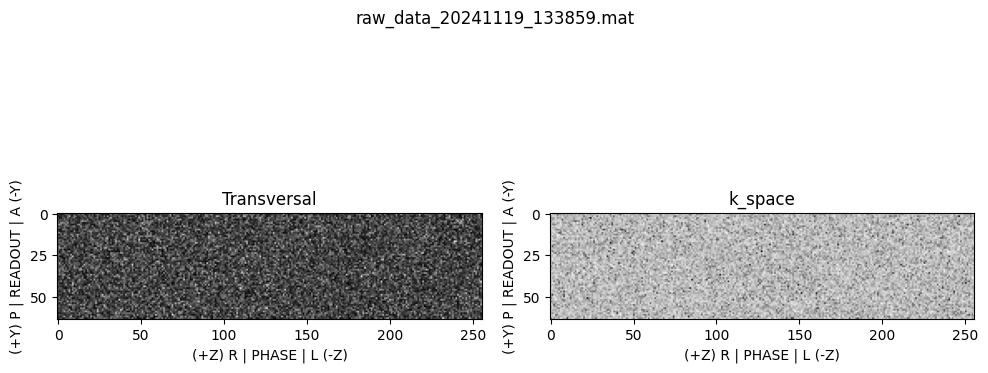

[{'widget': 'image',
  'data': array([[[23.22444948, 48.55715606, 20.75105492, ..., 11.91628698,
           15.07357841,  8.17944102],
          [11.57153616, 30.49639336, 16.54568124, ..., 30.64495977,
           37.04422723, 27.0784998 ],
          [ 3.33995481, 30.78706856, 31.18677084, ..., 10.66663937,
           28.36484623, 17.56547965],
          ...,
          [23.67325291, 53.8891281 , 48.62201777, ...,  2.13858951,
           18.41614839, 17.76031276],
          [17.31342557, 37.96087548, 21.70131474, ..., 13.04121951,
           17.03340702, 30.24391951],
          [46.16867354, 20.88908929, 14.65994953, ..., 35.77933683,
           26.90974758, 12.07448054]],
  
         [[26.17526036, 19.87042442, 54.45186293, ..., 22.80268143,
           37.54561345, 41.78512735],
          [25.82047592, 19.38439954,  8.92500648, ..., 35.17095831,
           51.94837233,  4.25438712],
          [12.9938737 , 10.61283595, 15.41630653, ..., 27.56326896,
           36.29012278, 14.24972488]

In [4]:
seq = TSESingleSlicePSEQ()
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=True, standalone=True)
seq.sequenceAnalysis(mode='Standalone')

TR fill: 488.87 ms
Creating batch_1.seq...
read 6 definitions, 1026 blocks, 14 shapes, 1 adc events, 6 rf events, 74 gradient shapes
batch_1.seq ready!
1 batches created with 49152 read points. Sequence ready!
Center frequecy set: 10.356623073073077 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
Detected multi-slice sequence! (3 slices)
Automatically detected matrix size: (3, 64, 256)
Moved: raw_data_20241119_133914 to experiments/acquisitions/2024.11.19


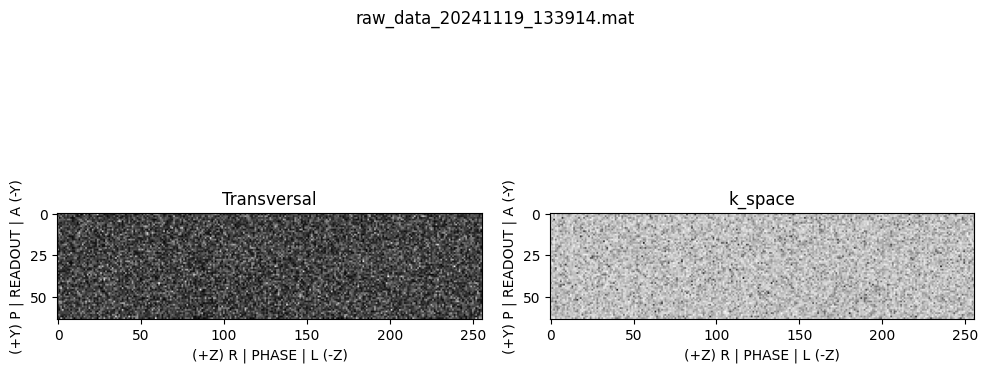

[{'widget': 'image',
  'data': array([[[16.05112252, 11.16349565, 31.34810136, ..., 25.03683862,
           20.04453405, 17.68419741],
          [31.73774928, 16.66140552, 19.69417306, ...,  6.89136645,
           19.28347631, 29.97840423],
          [22.91697946, 12.69791095, 15.11823233, ...,  7.0657131 ,
           26.82328989, 16.66790138],
          ...,
          [11.32175091, 55.60099084, 46.93676551, ..., 54.38834003,
           42.97995563, 34.67554997],
          [16.34915925, 35.09873662,  2.85047498, ..., 40.56482487,
           11.98828281, 23.24575939],
          [28.04450217, 27.51572922, 13.83312589, ..., 47.1248389 ,
           16.18235393, 12.62571385]],
  
         [[32.04076878, 29.82972422, 38.35110644, ...,  2.55889563,
           26.05852675, 26.12228911],
          [23.10675855, 36.54129489, 12.72780004, ..., 31.59427508,
           11.15739643, 21.16076703],
          [28.15151031, 29.16777466, 56.04181238, ..., 28.47730462,
           11.61764473, 39.78432769]

In [5]:
seq = TSESingleSlicePSEQ()
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=True, standalone=True)
seq.sequenceAnalysis(mode='Standalone')